# 02/12/24 - Adding least squares fitting option to forgo the time consuming MCMC for testing purposes.
# 12/26/23 - This notebook tests the modules "space_jam" and "total_mass_mge" in e.g. home/shawnknabel/Documents/slacs_kinematics/my_python_packages/space_jam.py

In [1]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
#plt.switch_backend('agg')
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
#import pickle
import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob

# astronomy/scipy
from astropy.io import fits
#from astropy.wcs import WCS
#from scipy.ndimage import rotate
#from scipy.ndimage import map_coordinates
#from scipy.optimize import least_squares as lsq
#from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
#from scipy.interpolate import interp1d
#from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")


################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [2]:
# bring in the space_jam and total_mass_mge modules

from space_jam import space_jam
from total_mass_mge import total_mass_mge

In [3]:
##################################################################################################################################

date_of_kin = '2024-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']
# get the revised KCWI sigmapsf
sigmapsf_table = pd.read_csv(f'{tables_dir}kcwi_sigmapsf_estimates.csv')

In [4]:
obj_name = obj_names[0]
SN = 15
mass_model='power_law'
anisotropy='const'
geometry='axi'
align='sph'
zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
p0 = [2.0, 0.4, 0.9, 1.0, 0.5, 7] # gamma0, q0, k_ani, einstein radius, k_mst, a_mst
bounds = [[1.4, 0.051, 0.0, 0.7, 0.0, 5 ], 
          [2.8, 1.0,   1.0, 2.0, 1.0, 10]]
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
fix_pars = [0, 0, 0, 0, 1, 1]
lambda_int= 1.0
nstep = 10
nwalkers = 12
ndim = 6
minimization = 'lsq'
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 1

welcome_to_the_jam = space_jam(kinematics_dir, jam_output_dir,
                                 obj_name, SN, mass_model, anisotropy, geometry, align, 
                                zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                               p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                               minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=False, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)

Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_02_13_v1/ will be overwritten.

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_02_13_v1/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]


In [5]:
welcome_to_the_jam.fit_lsq()

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Start lambda: 138.3  chi2: 1356.
Start p_free: 2.000 0.7400 0.9000 1.000
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 1  lambda: 138.3  chi2: 225.0  ratio: 0.9445
p_free: 2.228 0.8334 0.000 0.9601
h: 0.2285 0.09337 -0.9000 -0.03989
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `out

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()


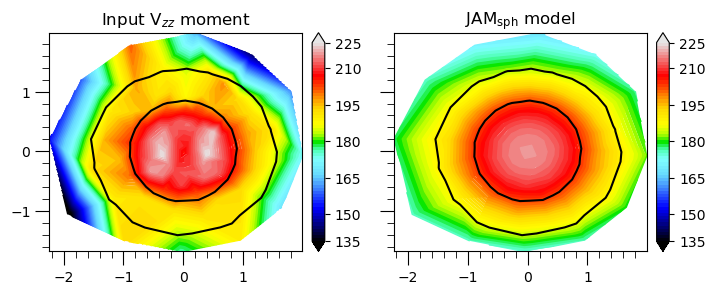

In [9]:
plt.show()

# Do one axi cyl

In [4]:
obj_name = obj_names[0]
SN = 15
mass_model='power_law'
anisotropy='const'
geometry='axi'
align='cyl'
zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
p0 = [2.0, 0.4, 0.9, 1.0, 0.5, 7] # gamma0, q0, k_ani, einstein radius, k_mst, a_mst
bounds = [[1.4, 0.051, 0.0, 0.7, 0.0, 5 ], 
          [2.8, 1.0,   1.0, 2.0, 1.0, 10]]
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
fix_pars = [0, 0, 0, 0, 1, 1]
lambda_int= 1.0
nstep = 10
nwalkers = 12
ndim = 6
minimization = 'lsq'
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 1

welcome_to_the_jam = space_jam(kinematics_dir, jam_output_dir,
                                 obj_name, SN, mass_model, anisotropy, geometry, align, 
                                zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                               p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                               minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=False, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)


Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_02_13_v1/

Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]


In [5]:
welcome_to_the_jam.fit_lsq()

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

Start lambda: 119.3  chi2: 301.9
Start p_free: 2.000 0.7400 0.9000 1.000
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

iter: 1  lambda: 119.3  chi2: 159.3  ratio: 0.9628
p_free: 2.138 0.7878 0.000 0.9323
h: 0.1385 0.04782 -0.9000 -0.06774
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `out

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()


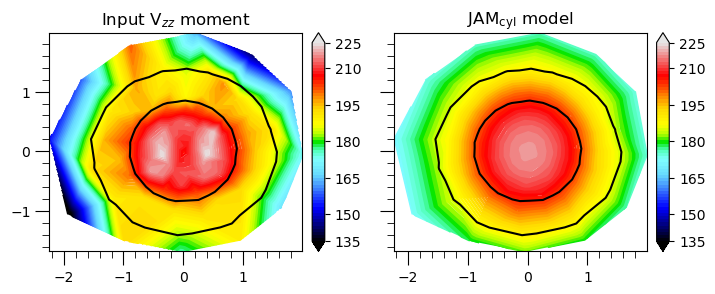

In [8]:
plt.show()

# Now spherical

In [4]:
obj_name = obj_names[0]
SN = 15
mass_model='power_law'
anisotropy='const'
geometry='sph'
align='sph'
zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
p0 = [2.0, 0.4, 0.9, 1.0, 0.5, 7] # gamma0, q0, k_ani, einstein radius, k_mst, a_mst
bounds = [[1.4, 0.051, 0.0, 0.7, 0.0, 5 ], 
          [2.8, 1.0,   1.0, 2.0, 1.0, 10]]
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
fix_pars = [0, 0, 0, 0, 1, 1]
lambda_int= 1.0
nstep = 10
nwalkers = 12
ndim = 6
minimization = 'lsq'
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 1

welcome_to_the_jam = space_jam(kinematics_dir, jam_output_dir,
                                 obj_name, SN, mass_model, anisotropy, geometry, align, 
                                zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                               p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                               minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=False, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)

Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_02_13_v1/ will be overwritten.

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_02_13_v1/

[0.0193628  0.1271433  0.245625   0.62405075 1.096469   1.30303874
 2.41793371 4.86902665 4.86902665] [0.80435509 0.8        0.80871018 0.82702924 0.8        0.9
 0.8        0.8        0.9       ]


TypeError: 'bool' object is not iterable

________________________________

In [7]:
%matplotlib inline

In [6]:
distance = cosmo.angular_diameter_distance(2.0)

In [7]:
distance

<Quantity 1726.33748003 Mpc>

In [15]:
a = 100

In [14]:
if distance.unit == 'Mpc':
    print('yes')

yes


In [11]:
welcome_to_the_jam.sigmapsf = 1.1425321673906823/2.355

In [12]:
welcome_to_the_jam.sigmapsf

0.4851516634355339

In [13]:
welcome_to_the_jam.run_mcmc()

Started Emcee please wait...
Progress is printed periodically


100%|██████████| 10/10 [14:09<00:00, 90.87s/it]


n accepted unique parameters 46
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_01_31_v1/SDSSJ0029-0055_2024_01_31_v1_space_jam.pkl
Job's finished!


In [14]:
%matplotlib inline

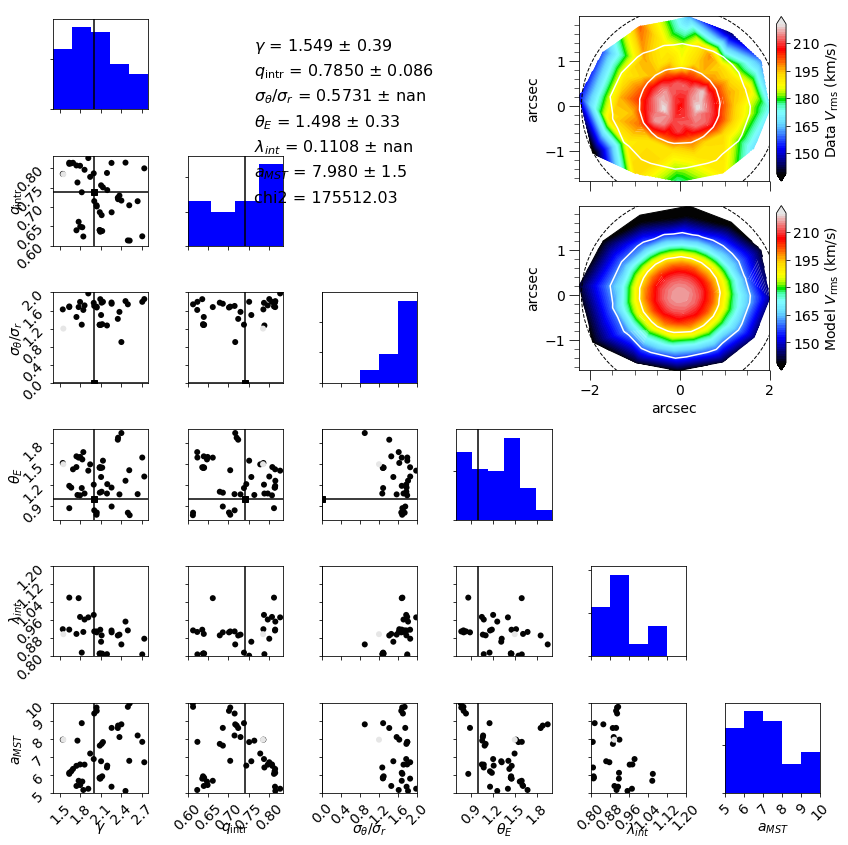

In [15]:
welcome_to_the_jam.summary_plot()

In [16]:
welcome_to_the_jam.save_space_jam()

Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_01_31_v1/SDSSJ0029-0055_2024_01_31_v1_space_jam.pkl


I need to change the function index_accepted_samples. It is resulting in 1212 instead of 1200 values

# New run, with cylindrical alignment

In [17]:
obj_name = obj_names[0]
SN = 15
mass_model='power_law'
anisotropy='const'
geometry='axi'
align='cyl'
zlens= zlenses[slacs_ix_table['Name']==obj_name]
zsource = zsources[slacs_ix_table['Name']==obj_name]
cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
p0 = [2.0, 0.4, 0.9, 1.0, 0.5, 7] # gamma0, q0, ratio0, einstein radius, lambda_int
bounds = [[1.4, 0.051, 0.0, 0.7, 0.0, 5 ], 
          [2.8, 1.0,   1.0, 2.0, 1.0, 10]]
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
nstep = 10
nwalkers = 12
ndim = 6
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 2

welcome_to_the_jam = space_jam(kinematics_dir, jam_output_dir,
                                 obj_name, SN, mass_model, anisotropy, geometry, align, 
                                zlens, zsource, cosmo, fast_slow,
                               p0, bounds, sigpar, prior_type, lensprior, 
                               sampler_args, date_time, run_id, plot=False, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)


Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_01_31_v2/

qobs_min  0.8
q_intr lower bound from qobs_min  0.38912877077009145
minimum inclination from qobs_min  5.010238276518078
Priors are now  ['uniform', 'gaussian', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 0.74, 0.9, 1.0, 0.5, 7]


In [18]:
welcome_to_the_jam.sigmapsf = 1.1425321673906823/2.355

In [19]:
welcome_to_the_jam.sigmapsf

0.4851516634355339

In [20]:
welcome_to_the_jam.run_mcmc()

Started Emcee please wait...
Progress is printed periodically


100%|██████████| 10/10 [11:14<00:00, 71.71s/it]


n accepted unique parameters 45
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055_2024_01_31_v2/SDSSJ0029-0055_2024_01_31_v2_space_jam.pkl
Job's finished!


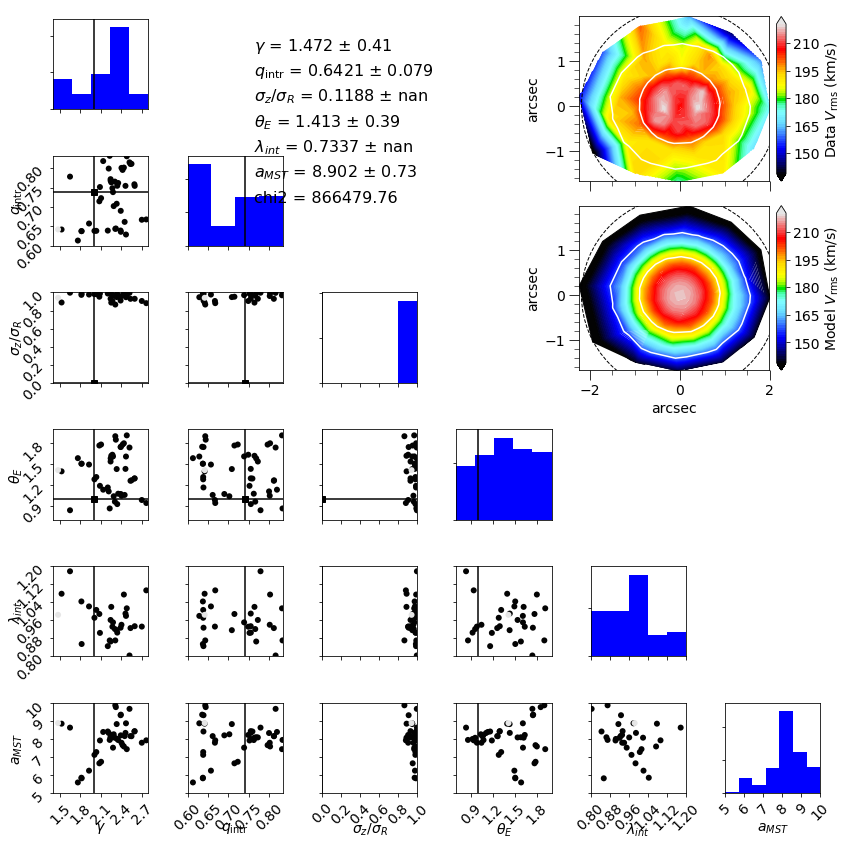

In [21]:
welcome_to_the_jam.summary_plot()

In [133]:
#################
# function to identify where samples were updated (accepted) vs rejected, so I can index the "anisotropy_ratio_samples" etc. properly                              
def index_accepted_samples(self):
    
    # create an array of the indices that are to be accepted for each of the steps
    self.index_accepted = np.zeros(self.pars.shape[0], dtype=int)
    
    # every step includes the initial state
    every_step = np.concatenate((self.initial_state, self.sampler.flatchain))
    nwalkers = self.sampler_args[1]
    
    # loop through each of hte walkers individually
    for i in range(nwalkers):
        # this walker will be every "nwalkers" of the parameters
        this_walker = every_step[i::nwalkers]
        # start with the initial state, it will be replaced by the first one that was accepted
        last_accepted_state = this_walker[0]
        # start with the index of the initial state
        last_accepted_index = i
        # loop through the steps of this walker
        for j, index in enumerate(this_walker):
            # skip the initialization
            if j==0:
                continue
            # if the walker is not equal to the last accepted state, then a new sample was accepted
            # the param_index is the index of the parameter in the shape nwalkers*nsteps
            param_index = (j-1)*nwalkers+i
            # the replace_index is the index of the "lambda_int" samples, shape (nwalkers+1)*nsteps to include the initial state
            replace_index = j*nwalkers+i
            if np.all(this_walker[j] != last_accepted_state):
                # report this index to the array
                self.index_accepted[param_index] = replace_index
                last_accepted_state = this_walker[j]
                last_accepted_index = replace_index
            else:
                self.index_accepted[(j-1)*nwalkers+i] = last_accepted_index
                
    # save the accepted lambda_int and anisotropy
    self.anisotropy_ratio_accepted = np.zeros(self.pars.shape[0], dtype=float)
    self.lambda_int_accepted = np.zeros(self.pars.shape[0], dtype=float)
    # loop through the steps
    for i in range(self.pars.shape[0]):
        self.anisotropy_ratio_accepted[i] = self.anisotropy_ratio_samples[self.index_accepted[i]]
        self.lambda_int_accepted[i] = self.lambda_int_samples[self.index_accepted[i]]

In [134]:
import types

In [135]:
welcome_to_the_jam.index_accepted_samples = types.MethodType(index_accepted_samples, welcome_to_the_jam)

In [136]:
welcome_to_the_jam.index_accepted_samples()

(array([ 28.,  62., 103., 294., 221., 125.,  83.,  10.,   5.,   9.]),
 array([0.96549403, 1.06468131, 1.16386859, 1.26305586, 1.36224314,
        1.46143042, 1.5606177 , 1.65980497, 1.75899225, 1.85817953,
        1.95736681]),
 <a list of 10 Patch objects>)

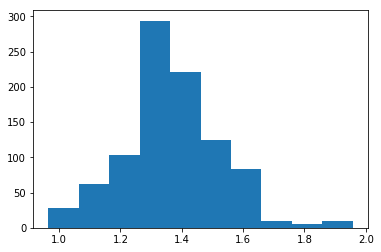

In [140]:
plt.hist(welcome_to_the_jam.anisotropy_ratio_accepted[~np.isnan(welcome_to_the_jam.anisotropy_ratio_accepted)])

In [187]:
welcome_to_the_jam.bounds = [[1.4, 0.051, 0.0, 0.7, 0.0, 5 ], 
                              [2.8, 1.0,   1.0, 2.0, 1.0, 10]]


In [188]:
###################
# function to plot summary
def summary_plot(self, save=False):

    """
    Print the best fitting solution with uncertainties.
    Plot the final corner plot with the best fitting JAM model.
    """

    # jam the best fit
    jam, surf_potential, lambda_int = self.jam_lnprob(self.bestfit, plot=True, test_prior=False, bestfit=True)
    if jam==0:
        return 'Cannot plot this bestfit'
    rms_model = jam.model
    flux_model = jam.flux

    plot_pars = self.pars.copy()
    plot_bounds = np.array(bounds)#self.bounds.copy()
    plot_truths = self.p0.copy()
    #truths should only be for gamma, theta_E and q_intr
    plot_truths[2] = 0
    plot_truths[-1] = 0
    plot_truths[-2] = 0
    # substitute the plot parameters with the ratios and lambda_ints
    plot_pars[:,2] = self.anisotropy_ratio_accepted
    plot_pars[:,-2] = self.lambda_int_accepted
    # bounds should change
    plot_bounds[0][2] = self.shape_anis_bounds[0]
    plot_bounds[1][2] = self.shape_anis_bounds[1]
    plot_bounds[0][-2] = 0.8
    plot_bounds[1][-2] = 1.2

    # calculate uncertainties in posterior
    perc = np.percentile(plot_pars, [15.86, 84.14], axis=0)  # 68% interval
    sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
    chi2_bestfit = self.chi2s[self.index_accepted][np.nanargmax(self.lnprob)]

    # For plotting, only show the finite probability points
    finite = np.isfinite(self.lnprob)

    # Produce final corner plot without trial values and with best fitting JAM
    plt.rcParams.update({'font.size': 14})
    plt.clf()
    corner_plot(plot_pars[finite], self.lnprob[finite], labels=self.labels, extents=plot_bounds, truths=plot_truths, truth_color='k', fignum=1)

    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()
    fig.set_size_inches((12,12))
    fig.tight_layout()

    i = 0                          
    # annotate the model results
    plt.annotate(f'chi2 = {np.around(chi2_bestfit, 2)}', (0.30, 0.97-(1+len(self.labels))*0.03), xycoords='figure fraction', fontsize=16)
    for label, best, sig in zip(self.labels, self.bestfit, sig_bestfit):
        string = f"{label} = {best:#.4g} ± {sig:#.2g}"
        plt.annotate(string, (0.30, 0.94-i*0.03), xycoords='figure fraction', fontsize=16) 
        i = i+1

    # plot circular reff
    reff_plot = plt.Circle((0,0), self.reff, color='k', fill=False, linestyle='--')

    # plot data
    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = self.Vrms.copy()
    rms1[self.goodbins] = symmetrize_velfield(self.xbin[self.goodbins], self.ybin[self.goodbins], self.Vrms[self.goodbins])
    vmin, vmax = np.percentile(rms1[self.goodbins], [0.5, 99.5])
    plot_velfield(self.xbin, self.ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)

    # plot circular reff again... can only patch one time
    reff_plot = plt.Circle((0,0), self.reff, color='k', fill=False, linestyle='--')

    # plot model
    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(self.xbin, self.ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    #plt.tick_params(labelbottom=False)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)

    if save==True:
        plt.savefig(f'{self.model_dir}{self.obj_name}_corner_plot_{self.model_name}_{self.date_time}.png', bbox_inches='tight')
        plt.savefig(f'{self.model_dir}{self.obj_name}_corner_plot_{self.model_name}_{self.date_time}.pdf', bbox_inches='tight')

    plt.show()
    plt.pause(1)

In [189]:
welcome_to_the_jam.summary_plot = types.MethodType(summary_plot, welcome_to_the_jam)

In [192]:
# adamet
#from adamet.adamet import adamet
from adamet.corner_plot import corner_plot
# emcee
import corner
#from IPython.display import display, Math
from plotbin.symmetrize_velfield import symmetrize_velfield
from plotbin.plot_velfield import plot_velfield

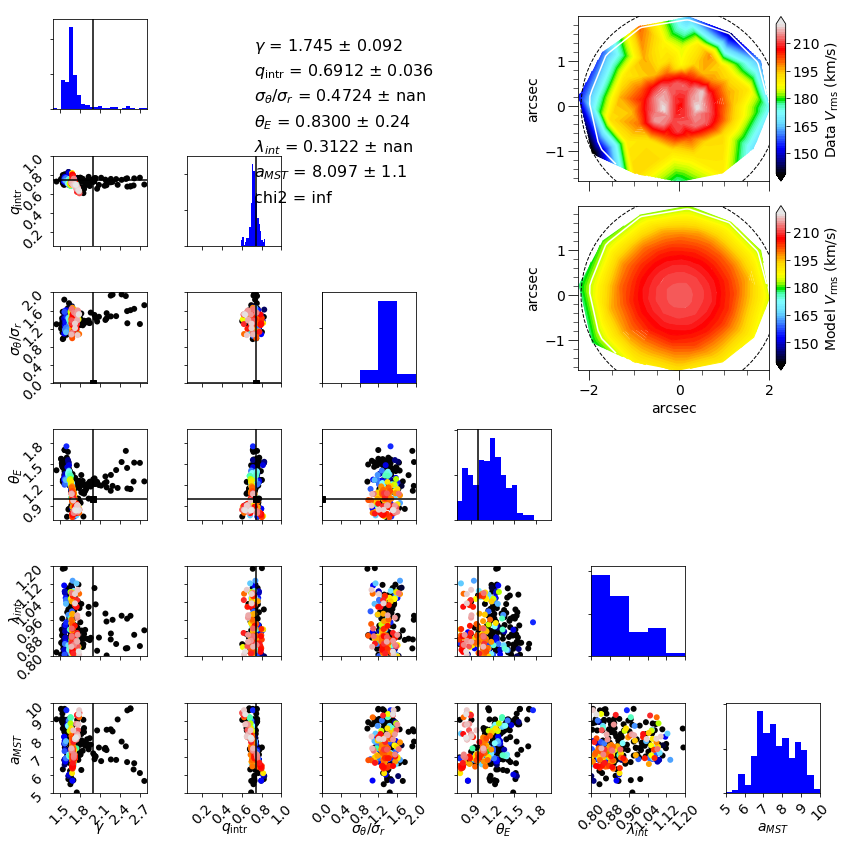

In [193]:
welcome_to_the_jam.summary_plot()

In [194]:
welcome_to_the_jam.pars[:,0]

array([1.57878397, 2.69734289, 2.76321155, 2.55723117, 2.29042444,
       1.93377682, 1.85595159, 1.45461334, 2.48760896, 1.75744497,
       1.61165149, 2.06001121, 1.57878397, 2.69734289, 2.76321155,
       2.55723117, 2.29042444, 1.93377682, 1.85595159, 1.45461334,
       2.48760896, 1.75744497, 1.63237308, 2.06001121, 1.57878397,
       2.69734289, 2.76321155, 2.55610109, 2.26291609, 1.8141755 ,
       1.85595159, 1.45461334, 2.42491928, 1.70644187, 1.63237308,
       2.06001121, 1.61208706, 2.6124254 , 2.60329623, 2.55610109,
       2.26291609, 1.8141755 , 1.85595159, 1.56264802, 2.18379026,
       1.66209347, 1.64143092, 2.06001121, 1.61208706, 2.5067342 ,
       2.19991687, 2.51032818, 2.26291609, 1.8141755 , 1.85595159,
       1.57593004, 2.02209694, 1.66209347, 1.67358419, 1.9502981 ,
       1.57628025, 2.5067342 , 2.19991687, 2.51032818, 2.26291609,
       1.80493316, 1.85595159, 1.57593004, 2.02209694, 1.66209347,
       1.67358419, 1.9502981 , 1.57628025, 2.5067342 , 2.19991

In [186]:
welcome_to_the_jam.bestfit

array([1.74487714, 0.69124458, 0.47237863, 0.83003169, 0.31217544,
       8.09736218])

In [159]:
welcome_to_the_jam.pars[np.nanargmax(welcome_to_the_jam.lnprob)]

array([1.74487714, 0.69124458, 0.47237863, 0.83003169, 0.31217544,
       8.09736218])

In [158]:
welcome_to_the_jam.jam_lnprob

<bound method space_jam.jam_lnprob of <space_jam.space_jam object at 0x7ff4e2b926d8>>

In [151]:
welcome_to_the_jam.bounds

[[1.4, 0.6, 0.0, 0.7, 0.8, 5], [2.8, 0.8333736449437164, 2.0, 2.0, 1.2, 10]]

In [42]:
nwalkers=12
nsteps=100

indices = np.zeros(nsteps)
last_true = 0
for i in range(nwalkers):
    for , index in enumerate(welcome_to_the_jam.index_accepted[::nwalkers]):
    if i == 0:
        continue
    if index == True:
        indices[i-1] = i
        last_true = i
    else:
        indices[i-1] = last_true

In [ ]:
    every_step = np.concatenate((self.initial_state, self.sampler.flatchain))
    nwalkers = self.sampler_args[1]

    for i in range(nwalkers):
        this_walker = every_step[i::nwalkers]
        accepted_state = this_walker[0]
        for j in range(len(this_walker)-1):
            if np.all(this_walker[j] != accepted_state):
                self.index_accepted[(j+1)*nwalkers+i] = 1
                accepted_state = this_walker[j]
            else:
                self.index_accepted[j*nwalkers+i] = 1

In [43]:
indices

array([  1.,   2.,   3.,   3.,   5.,   5.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  21.,
        23.,  24.,  25.,  26.,  26.,  28.,  28.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  38.,  40.,  40.,  42.,  43.,  44.,
        44.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  56.,  58.,  59.,  60.,  60.,  62.,  63.,  63.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  71.,  73.,  74.,  75.,  76.,  77.,
        78.,  78.,  80.,  81.,  82.,  83.,  84.,  85.,  85.,  87.,  88.,
        88.,  90.,  91.,  92.,  92.,  94.,  95.,  96.,  96.,  98.,  98.,
       100.])

In [22]:
welcome_to_the_jam.lambda_int_samples.shape

(1212,)

In [23]:
welcome_to_the_jam.anisotropy_ratio_samples.shape

(1212,)

In [26]:
welcome_to_the_jam.pars.shape

(1200, 6)

In [33]:
welcome_to_the_jam.index_accepted[welcome_to_the_jam.index_accepted].shape

(959,)

In [ ]:
welcome_to_the_jam.bestfit

# Previous one

In [7]:
welcome_to_the_jam.bestfit

array([2.79409162, 0.60703747, 0.61175061, 1.65344041, 0.41083673,
       8.2335574 ])

In [8]:
welcome_to_the_jam.bounds

[[1.4, 0.6, 0.0, 0.7, 0.8, 5], [2.8, 0.8333736449437164, 2.0, 2.0, 1.2, 10]]